In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [8]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

In [9]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [10]:
df.head()

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,-0.117,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,-0.056,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348
2,3,37.0,1,NaN,69.0,SR,-0.029,-0.035,-0.054,-0.078,...,-0.040,-0.051,-0.026,-0.032,-0.052,-0.039,-0.034,-0.029,-0.048,-0.049
3,4,24.0,0,NaN,82.0,SR,-0.054,-0.053,-0.063,-0.060,...,-0.312,-0.511,-0.280,-0.076,-0.012,0.001,-0.003,0.026,0.026,0.028
4,5,19.0,1,NaN,70.0,SR,-0.034,-0.038,-0.057,-0.066,...,0.005,0.001,0.003,0.013,0.018,-0.001,0.007,0.000,-0.003,-0.012


In [11]:
df['rhythm_diag'] = df['rhythm_diag'].map(dict(OTHER=2,AFIB=1, SR=0))
df.rhythm_diag.value_counts()

0    16782
2     3541
1     1514
Name: rhythm_diag, dtype: int64

In [12]:
df_minority = df[df['rhythm_diag']==1]
df_majority_SR = df[df['rhythm_diag']==0]
df_majority_OTHER = df[df['rhythm_diag']==2]
maj_class_SR = resample(df_majority_SR,
                         replace=True,
                         n_samples=1514,
                         random_state=123)
maj_class_OTHER = resample(df_majority_OTHER,
                             replace=True,
                             n_samples=1514,
                             random_state=123)
df=pd.concat([df_minority,maj_class_SR,maj_class_OTHER])

In [13]:
df.rhythm_diag.value_counts()

0    1514
1    1514
2    1514
Name: rhythm_diag, dtype: int64

In [14]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [15]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [16]:
df_other = df[df.rhythm_diag == 2]
df_other = df_other.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_other.reset_index(drop=True, inplace=True)
df_other.shape

(1514, 1000)

In [129]:
X_sr = df_sr.values
X_afib = df_afib.values
X_other = df_other.values

### Get individuals HeartBeats

In [18]:
def maior_valor_sinal(sinal):
    maior_valor = 0
    for i in range(len(sinal)):
        if(sinal[i] > maior_valor):
            maior_valor = sinal[i]
    return maior_valor

In [19]:
def R_peak_detection(sinal):
    sinal = filter_data(sinal,100)
    indice_aux = 0
    indice_maximo = []
    valor_aux = 0
    valor_maximo = []
    flag_contagem = 0
    indice_temp = 0
    valor_temp = 0
    i = 0
    valor_referencia = maior_valor_sinal(sinal)*0.5
    #print(valor_referencia)
    while i < len(sinal):
        if(sinal[i] > (valor_referencia)):
            indice_aux = i;
            valor_aux = sinal[i];
            if((indice_aux + 5) > len(sinal)):
                pass
            else:
                for x in range(5):
                    if(sinal[indice_aux+x] > valor_aux):
                        indice_temp = indice_aux + x
                        valor_temp = sinal[indice_aux + x]
                        valor_aux = sinal[indice_aux+x]
                    else:
                        flag_contagem = flag_contagem + 1
                indice_maximo.append(indice_temp) 
                valor_maximo.append(valor_temp) 
                if(flag_contagem == 5):
                    indice_maximo.append(i) 
                    valor_maximo.append(sinal[i]) 
                flag_contagem = 0
                indice_temp = 0
                valor_temp = 0
                indice_aux = 0
                valor_aux = 0
                #print(indice_temp+i)
                #print(indice_maximo)
                i = i + 30
        i = i + 1
    contador_zeros = 0
    for j in range (len(indice_maximo)):
        if(indice_maximo[j] == 0):
            contador_zeros = contador_zeros + 1
    for k in range (len(indice_maximo) - contador_zeros):
        if(indice_maximo[k] == 0):
            indice_maximo = np.delete(indice_maximo, k)
    return indice_maximo

In [20]:
def Get_Heartbeats(sinal, frequencia_amostragem, plot = True):
    picos_R = R_peak_detection(sinal)
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 25) and (difference_peaks_after >= 35)):
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 25 and (difference_peaks_after < 35)):
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after >= 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after < 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    #print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [21]:
def Get_Complete_Heartbeats(sinal, frequencia_amostragem, plot = True):
    templates = []
    templates_aux = []
    hb = []
    hb_aux = []
    for i in range(len(sinal)): 
        hb_aux = Get_Heartbeats(sinal[i], 100, False)
        for j in range(len(hb_aux)):
            hb.append(hb_aux[j])
    return np.array(hb)

In [130]:
X_sr = Get_Complete_Heartbeats(X_sr, 100, plot = False)
X_sr.shape

(14965, 60)

In [131]:
y_sr = []
y_sr_content = [0,1,0]
for i in range(len(X_sr)):
    y_sr.append(y_sr_content)
y_sr = np.array(y_sr)
y_sr.shape

(14965, 3)

In [132]:
X_afib = Get_Complete_Heartbeats(X_afib, 100, plot = False)
X_afib.shape

(18567, 60)

In [133]:
y_afib = []
y_afib_content = [0,0,1]
for i in range(len(X_afib)):
    y_afib.append(y_afib_content)
y_afib = np.array(y_afib)
y_afib.shape

(18567, 3)

In [134]:
X_other = Get_Complete_Heartbeats(X_other, 100, plot = False)
X_other.shape

(16186, 60)

In [135]:
y_other = []
y_other_content = [1,0,0]
for i in range(len(X_other)):
    y_other.append(y_other_content)
y_other = np.array(y_other)
y_other.shape

(16186, 3)

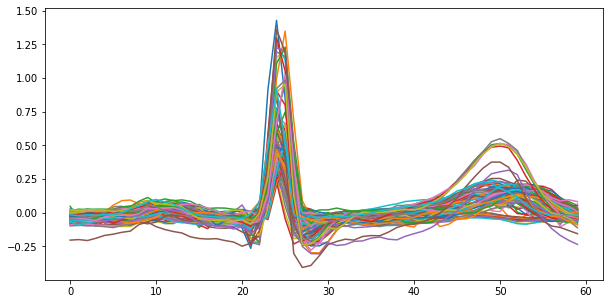

In [28]:
for i in range(100):
    plt.plot(X_sr[i])

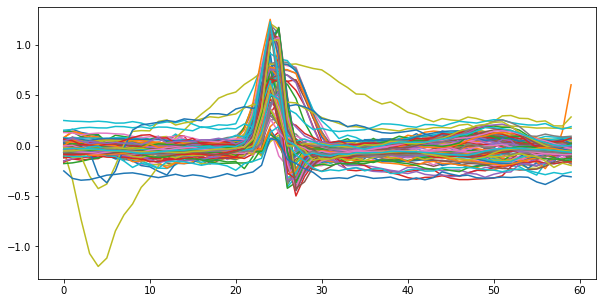

In [29]:
for i in range(100):
    plt.plot(X_afib[i])

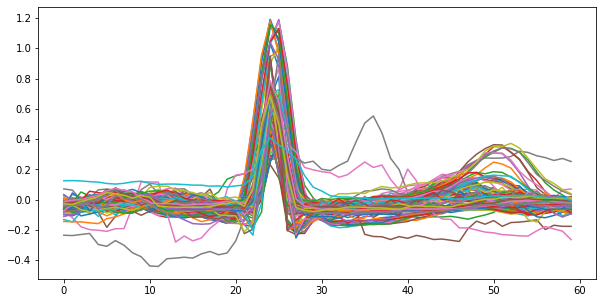

In [30]:
for i in range(100):
    plt.plot(X_other[i])

In [136]:
X = np.concatenate((X_other, X_sr, X_afib), axis=0)
X.shape

(49718, 60)

In [137]:
y = np.concatenate((y_other, y_sr, y_afib), axis=0)
y.shape

(49718, 3)

In [33]:
#saving data
from numpy import save
save('X_07_09.npy', X)
save('y_07_09.npy', y)

In [34]:
from numpy import load
# Getting data

X = load('X_07_09.npy')
y = load('y_07_09.npy')

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    random_state=21)

In [111]:
def normalize_data(Xt):
    Xt_full = []
    for i in range(len(Xt)):
        norm = ((Xt[i] - Xt[i].min())/(Xt[i].max() - Xt[i].min()))
        Xt_full.append(norm)

    Xt_full = np.array(Xt_full)
    print(Xt_full.shape)
    return Xt_full

In [139]:
print (X_train.min(), X_train.max())
X_train = normalize_data(X_train)
print (X_train.min(), X_train.max())

-4.729 2.713
(39774, 60)
0.0 1.0


In [140]:
print (X_test.min(), X_test.max())
X_test = normalize_data(X_test)
print (X_test.min(), X_test.max())

-1.84 3.156
(9944, 60)
0.0 1.0


In [141]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print(X_train.shape, X_test.shape)

(39774, 60, 1) (9944, 60, 1)


In [142]:
samples, features, depht = X_train.shape
print(samples, features, depht)

39774 60 1


In [41]:
import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [143]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [144]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 60, 32)            192       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 60, 32)            5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 28, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 28, 32)            5152      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 28, 32)            5152      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 32)           

In [145]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [146]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [147]:
EPOCHS = 50

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
995/995 [==============================] - 11s 10ms/step - loss: 0.9558 - accuracy: 0.5063 - val_loss: 0.8138 - val_accuracy: 0.6005
Epoch 2/50
995/995 [==============================] - 10s 10ms/step - loss: 0.8306 - accuracy: 0.6072 - val_loss: 0.7721 - val_accuracy: 0.6401
Epoch 3/50
995/995 [==============================] - 10s 10ms/step - loss: 0.7924 - accuracy: 0.6347 - val_loss: 0.8009 - val_accuracy: 0.6263
Epoch 4/50
995/995 [==============================] - 10s 10ms/step - loss: 0.7825 - accuracy: 0.6402 - val_loss: 0.7619 - val_accuracy: 0.6532
Epoch 5/50
995/995 [==============================] - 10s 10ms/step - loss: 0.7697 - accuracy: 0.6453 - val_loss: 0.7302 - val_accuracy: 0.6694
Epoch 6/50
995/995 [==============================] - 10s 10ms/step - loss: 0.7580 - accuracy: 0.6544 - val_loss: 0.7418 - val_accuracy: 0.6603
Epoch 7/50
995/995 [==============================] - 10s 10ms/step - loss: 0.7491 - accuracy: 0.6594 - val_loss: 0.7220 - val_accuracy:

In [148]:
# summarize history for loss
def summarize_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

Model Accuraccy:  0.71


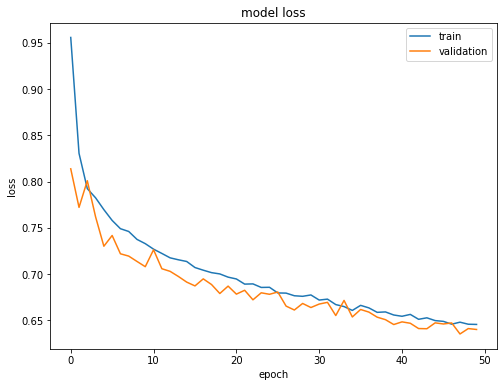

In [149]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [150]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

In [157]:
y_pred = model.predict(X_test)

In [160]:
y_pred = y_pred > 0.60

In [153]:
indice_2 = []
for i in range(len(y_pred)):
    indice_2.append(np.argmax(y_pred[i]))
indice_2 = np.array(indice_2)
print(indice_2.shape)
indice_2[0:20]

(9944,)


array([2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0],
      dtype=int64)

In [161]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

       OTHER       0.80      0.34      0.47      3237
          SR       0.69      0.57      0.63      2935
        AFIB       0.87      0.76      0.81      3772

   micro avg       0.79      0.57      0.66      9944
   macro avg       0.78      0.56      0.64      9944
weighted avg       0.79      0.57      0.65      9944
 samples avg       0.57      0.57      0.57      9944



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


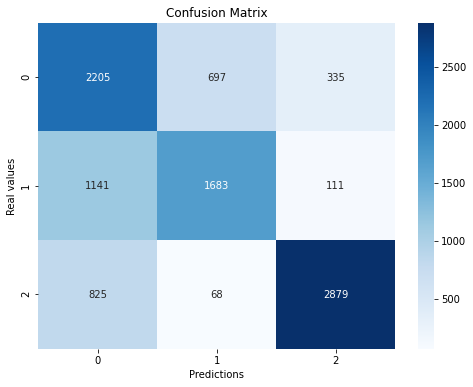

In [162]:
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['OTHER','SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

### Model using the original way to get the heartbeats with 100 points

In [116]:
def Get_Heartbeats_2(sinal, frequencia_amostragem, plot = True):
    picos_R = R_peak_detection(sinal)
    heartbeats = []
    indice_min = 0
    indice_max = 0
    tamanho_sinal = len(sinal)
    for i in range(len(picos_R)):
        indice_min = picos_R[i] - (0.4*frequencia_amostragem)
        indice_max = picos_R[i] + (0.6*frequencia_amostragem)
        if((indice_min > 0) & (indice_max < tamanho_sinal)):
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
    heartbeats = np.array(heartbeats)
    #print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [117]:
def Get_Complete_Heartbeats_2(sinal, frequencia_amostragem, plot = True):
    templates = []
    templates_aux = []
    hb = []
    hb_aux = []
    for i in range(len(sinal)): 
        hb_aux = Get_Heartbeats_2(sinal[i], 100, False)
        for j in range(len(hb_aux)):
            hb.append(hb_aux[j])
    return np.array(hb)

In [132]:
X_sr = df_sr.values
X_afib = df_afib.values
X_other = df_other.values

In [133]:
X_sr = Get_Complete_Heartbeats_2(X_sr, 100, plot = False)
X_sr.shape

(16228, 100)

In [134]:
y_sr = []
y_sr_content = [1,0,0]
for i in range(len(X_sr)):
    y_sr.append(y_sr_content)
y_sr = np.array(y_sr)
y_sr.shape

(16228, 3)

In [135]:
X_afib = Get_Complete_Heartbeats_2(X_afib, 100, plot = False)
X_afib.shape

(19452, 100)

In [136]:
y_afib = []
y_afib_content = [0,1,0]
for i in range(len(X_afib)):
    y_afib.append(y_afib_content)
y_afib = np.array(y_afib)
y_afib.shape

(19452, 3)

In [137]:
X_other = Get_Complete_Heartbeats_2(X_other, 100, plot = False)
X_other.shape

(17307, 100)

In [138]:
y_other = []
y_other_content = [0,0,1]
for i in range(len(X_other)):
    y_other.append(y_other_content)
y_other = np.array(y_other)
y_other.shape

(17307, 3)

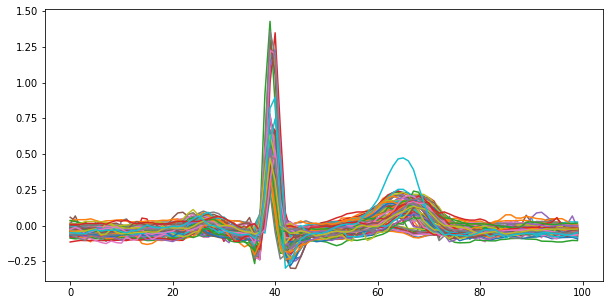

In [139]:
for i in range(100):
    plt.plot(X_sr[i])

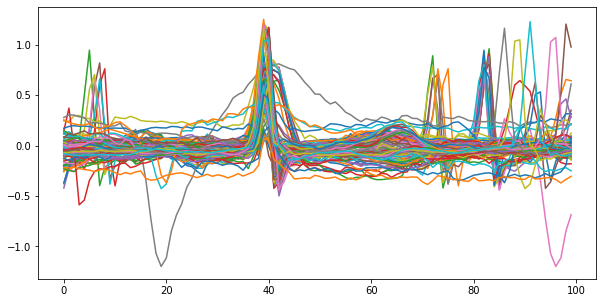

In [140]:
for i in range(100):
    plt.plot(X_afib[i])

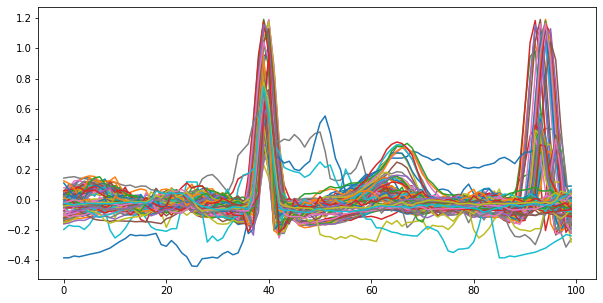

In [141]:
for i in range(100):
    plt.plot(X_other[i])

In [142]:
X = np.concatenate((X_sr, X_afib, X_other), axis=0)
X.shape

(52987, 100)

In [143]:
y = np.concatenate((y_sr, y_afib, y_other), axis=0)
y.shape

(52987, 3)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    random_state=21)

In [145]:
print (X_train.min(), X_train.max())
X_train = normalize_data(X_train)
print (X_train.min(), X_train.max())

-4.729 3.156
(42389, 100)
0.0 1.0


In [146]:
print (X_test.min(), X_test.max())
X_test = normalize_data(X_test)
print (X_test.min(), X_test.max())

-2.357 4.398
(10598, 100)
0.0 1.0


In [147]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [148]:
print(X_train.shape, X_test.shape)

(42389, 100, 1) (10598, 100, 1)


In [149]:
samples, features, depht = X_train.shape
print(samples, features, depht)

42389 100 1


In [150]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [151]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 100, 32)           192       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 48, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 22, 32)           

In [152]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [153]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
1060/1060 [==============================] - 19s 17ms/step - loss: 0.8894 - accuracy: 0.5647 - val_loss: 0.6800 - val_accuracy: 0.6975
Epoch 2/100
1060/1060 [==============================] - 17s 16ms/step - loss: 0.7159 - accuracy: 0.6862 - val_loss: 0.6556 - val_accuracy: 0.7143
Epoch 3/100
1060/1060 [==============================] - 17s 16ms/step - loss: 0.6858 - accuracy: 0.7018 - val_loss: 0.6236 - val_accuracy: 0.7295
Epoch 4/100
1060/1060 [==============================] - 15s 15ms/step - loss: 0.6708 - accuracy: 0.7109 - val_loss: 0.6068 - val_accuracy: 0.7350
Epoch 5/100
1060/1060 [==============================] - 17s 16ms/step - loss: 0.6574 - accuracy: 0.7173 - val_loss: 0.6025 - val_accuracy: 0.7396
Epoch 6/100
1060/1060 [==============================] - 17s 16ms/step - loss: 0.6450 - accuracy: 0.7222 - val_loss: 0.5995 - val_accuracy: 0.7397
Epoch 7/100
1060/1060 [==============================] - 18s 17ms/step - loss: 0.6371 - accuracy: 0.7269 - val_loss: 0

Model Accuraccy:  0.79


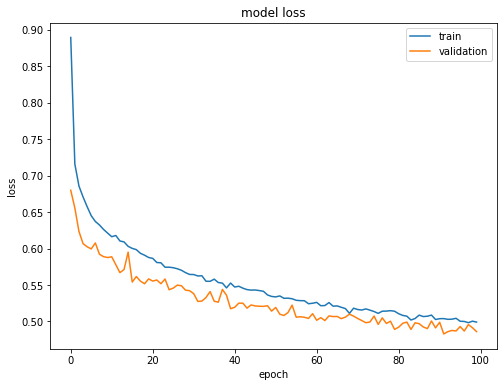

In [154]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.71      0.84      0.77      3292
        AFIB       0.86      0.91      0.88      3839
       OTHER       0.86      0.55      0.67      3467

   micro avg       0.80      0.77      0.78     10598
   macro avg       0.81      0.76      0.77     10598
weighted avg       0.81      0.77      0.78     10598
 samples avg       0.77      0.77      0.77     10598



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


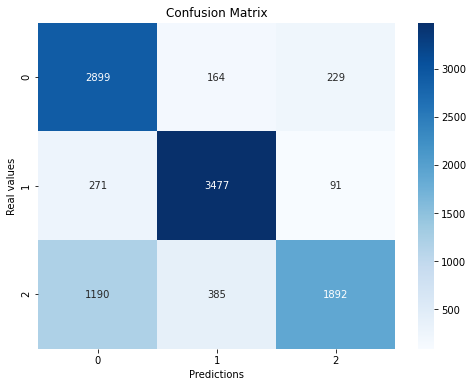

In [155]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB', 'OTHER']))
plot_conf_matrix(y_test, y_pred)